# Analyse de signaux de flûte

##  *Introduction*

Pour cette première étude, nous nous intéressons à des sons provenant d’une flûte. Afin de réaliser cette étude, nous comparons les résultats obtenus par le biais de plusieurs algorithmes différents. Nous nous concentrons dans un premier temps sur l’algorithme Fast Fourier Transform, puis nous étudions l’algorithme Periodogram, celui de Burg et enfin l’algorithme MUSIC.

## 1 Définition des variables & fonctions

### 1.1 Import des librairie

Outre les librairies communes utilisées lors de ce genre d'analyse (matplotlib, scipy, numpy, pylab,...), on importe les librairies **librosa**, **pysine** et **spectrum** pour appliquer nos algorithmes.

In [1]:
import collections
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as scw
import scipy.signal as scs
import scipy.linalg as scl
import sklearn
import wavio
import scipy

from __future__ import division
from IPython.display import Audio
from math import log2, pow
from pylab import *
from pysine import sine
from spectrum import *

%matplotlib inline

### 1.2 Définition des fonctions

Dans ce note notebook, on créé 3 fonction qui sont utilisés par la suite dans différentes méthodes :
* **plotwave** : une fonction qui permet d'afficher le signal en fonction du temps
* **pitch** : une fonction qui associe une note à la fréquence donnée en entrée
* **spectral_centroid** : une fonction permettant d'afficher le barycentre du signal

In [2]:
def plotwave(fs, signal, maxf=None):
    """Visualize (a segment of) a wave file."""
    # maxf = maximum number of frames
    frames = scipy.arange(signal.size)   # x-axis
    if maxf:
        plt.figure(figsize=(16, 6))
        plt.plot(frames[:maxf], signal[:maxf])
        plt.xticks(scipy.arange(0, maxf, 0.5*fs), scipy.arange(0, maxf/fs, 0.5))
        plt.show()
    else:
        plt.figure(figsize=(16, 6))
        plt.plot(frames, signal)
        plt.xticks(scipy.arange(0, signal.size, 0.5*fs), scipy.arange(0, signal.size/fs, 0.5))
        plt.show()

In [3]:
def pitch(freq): #associe à chaque fréquence une note
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = int(h % 12)
    return name[n] + str(octave)

In [4]:
def spectral_centroid(x, samplerate): 
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

### 1.3 Définitions des variables

Dans la cellule suivante, on définit les variables qui seront utilisées tout au long du notebook

In [5]:
A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] #dictionnaire des notes

fs, wave_orig = scw.read('fluteircam.wav')
N = len(wave_orig)

wave = wave_orig[int(0.3*N/13.685):int(13.10*N/13.685)] #le signal dont on a tronqué le début et la fin
N1 = len(wave)
wavio.write("signalmod.wav", wave, fs, sampwidth=3)

y, sr = librosa.load('signalmod.wav')
cent = librosa.feature.spectral_centroid(y=y, sr=sr) #barycentre du signal tronqué
S, phase = librosa.magphase(librosa.stft(y=y))
to=0.025
t1,t2 = 0.8, 0.825
dur = wave.size/fs
wave1 = wave[int(t1*N1/dur):int(t2*N1/dur)] #petite partie du signal
L = len(wave1)

In [6]:
print('Sampling rate:', fs)
print('Audio length:', wave_orig.size/fs, 'seconds')
print('Lowest amplitude:', min(wave_orig))
print('Highest amplitude:', max(wave_orig))
Audio('fluteircam.wav')

Sampling rate: 32000
Audio length: 13.685 seconds
Lowest amplitude: -7864
Highest amplitude: 9186


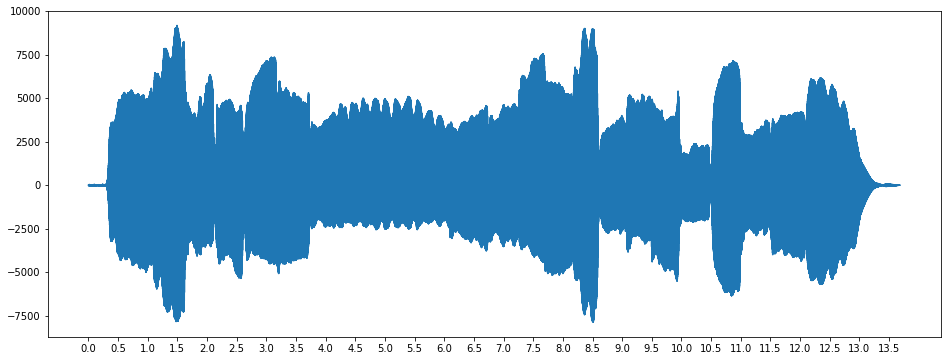

In [7]:
plotwave(fs, wave_orig)

## 2 Algorithmes non-paramétriques

### 2.1 Fast Fourier Transform

Nous appliquons et étudions le comportement de la Transformée de Fourier Rapide sur le signal. Il s’agit d’une approche non paramétrique où l’on calcule la transformée de Fourier du signal dont on pourra extraire le spectre.

1482.1124544344461
437920


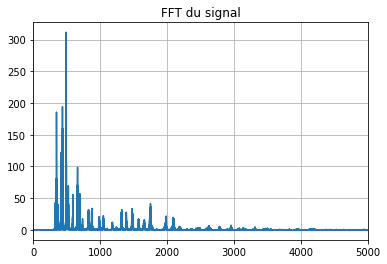

In [8]:
#FFT + fréquence barycentrique
xf = np.linspace(-1.0/2.0*fs, 1.0/2.0*fs, N)
yf = scipy.fftpack.fft(wave_orig)
yf = np.fft.fftshift(yf)
fig, ax = plt.subplots()

ax.plot(xf, 1.0/N *np.abs(yf) )
plt.xlim(0,5000)
plt.title('FFT du signal')

plt.grid()
print(spectral_centroid(wave_orig, samplerate=fs))
print(N)

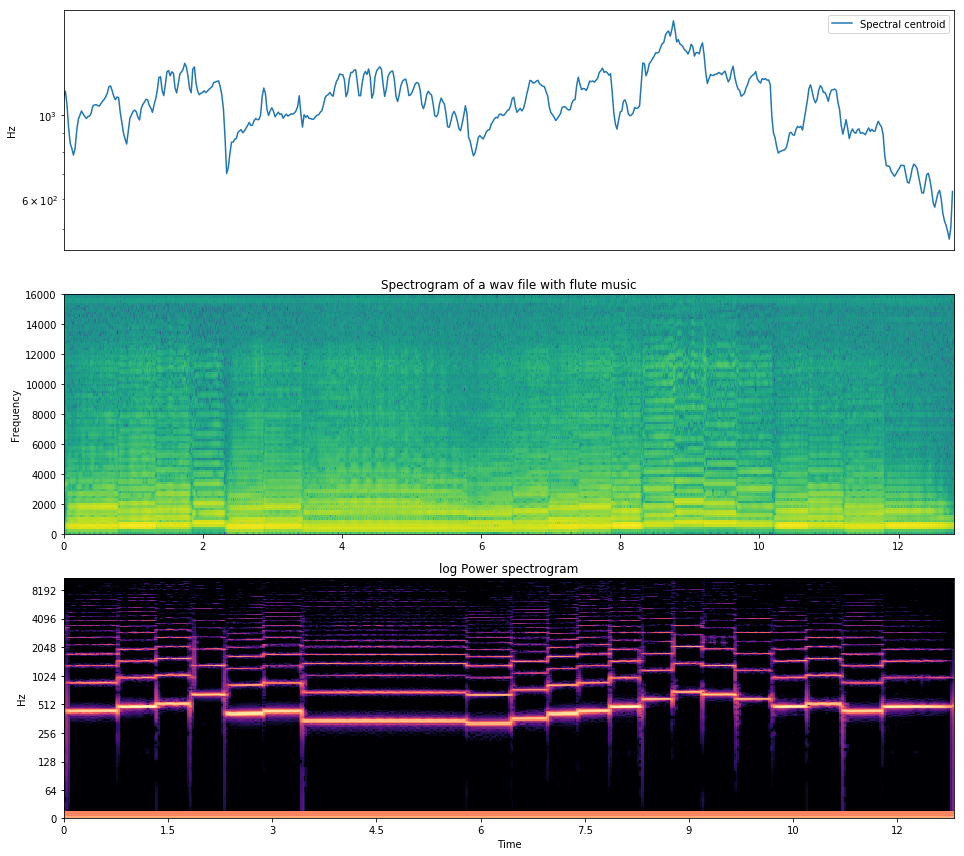

Audio length: 12.8 seconds


In [9]:
# Plot the signal read from wav file
plt.figure(figsize=(13.5, 12))

#Premier diagramme : barycentre à chaque instant
plt.subplot(3, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()


#Second diagramme
plt.subplot(3, 1, 2)
plt.title('Spectrogram of a wav file with flute music')
plt.specgram(wave, NFFT=200, Fs=fs) 
plt.ylabel('Frequency')

#Troisième diagramme
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
plt.title('log Power spectrogram')


plt.tight_layout()
plt.show()

print('Audio length:', wave.size/fs, 'seconds')
Audio('signalmod.wav')

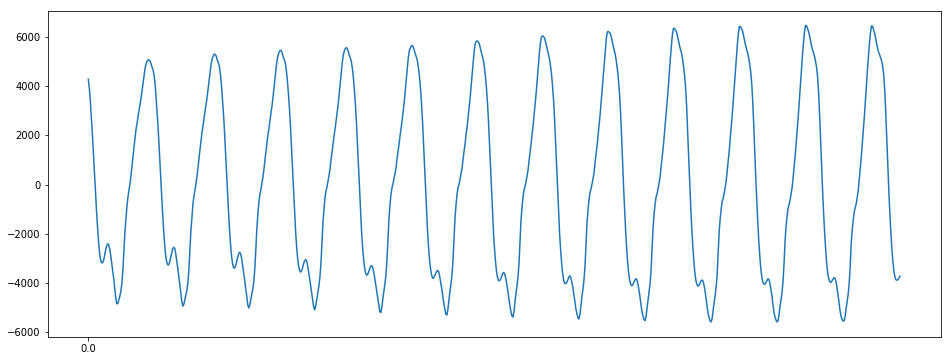

480.0


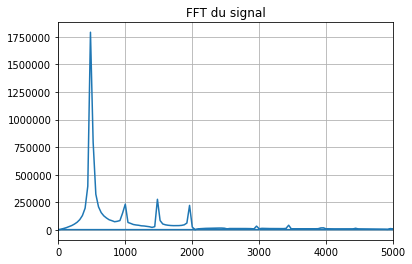

In [10]:
plotwave(fs, wave1) #on voit les harmoniques sur une petite partie du signal

xf = np.linspace(-1.0/2.0*fs, 1.0/2.0*fs, L)
#yf = scipy.fftpack.fft(wave1)
#yf = np.fft.fftshift(yf)
fig, ax = plt.subplots()
n = len(wave1)
Y = scipy.fftpack.fft(wave1)
freq = scipy.fftpack.fftfreq(n) * fs
y1 = abs(freq[np.argmax(abs(Y))])
ax.plot(freq, abs(Y))
#ax.plot(xf, 1.0/L *np.abs(yf) )
plt.xlim(0,5000)
plt.title('FFT du signal')
plt.grid()
print(y1)


In [11]:
print(spectral_centroid(wave1, samplerate=fs))         
wavio.write("2note.wav", wave1, fs, sampwidth=3)
Audio('2note.wav')

2446.2170730484854


In [12]:
#Retire les fréquences fondamentales à chaque intervalle to_1
Tn = []
eps_1 = 5
to_1 = to
k_1 = np.arange(0,dur,to_1)
ymax = 0
n = 0
t = float(1/fs)
Y1 = []
for i in k_1:
    n = len(wave[int(i*N1/dur):int((i+to_1)*N1/dur)])
    Y = scipy.fftpack.fft(wave[int(i*N1/dur):int((i+to_1)*N1/dur)])
    freq = scipy.fftpack.fftfreq(n) * fs
    y1 = abs(freq[np.argmax(abs(Y))])
    Y1.append(y1)
#    plt.plot(freq,abs(Y))
#    plt.xlim(0,4500)
#    plt.figure()
    if (abs(y1-ymax)>eps_1):
        Tn.append(i)
    ymax = y1

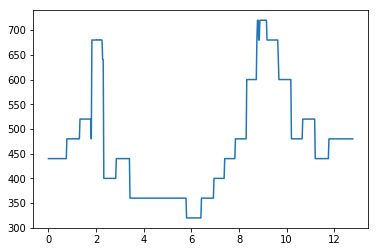

In [13]:
plt.plot(k_1,Y1)
Tn.append(dur)

In [14]:
#Créer un dictionnaire qui indique les notes et leur durée
notes=collections.OrderedDict()
for t in range(len(Tn)-1):
    lo = len(wave[int(Tn[t]*N1/dur):int(Tn[t+1]*N1/dur)])

    Y = scipy.fftpack.fft(wave[int(Tn[t]*N1/dur):int(Tn[t+1]*N1/dur)])
    freq = scipy.fftpack.fftfreq(lo) * fs
    note=abs(freq[np.argmax(abs(Y))])
    notes[str(round(Tn[t],3))+' to '+str(round(Tn[t+1],3))]=[note]
    notes[str(round(Tn[t],3))+' to '+str(round(Tn[t+1],3))].append(pitch(note))
#    plt.plot(freq,abs(Y))
#    plt.xlim(0,4500)
#    plt.figure()

In [15]:
notes

OrderedDict([('0.0 to 0.775', [438.7096774193549, 'A4.0']),
             ('0.775 to 1.325', [492.72727272727275, 'B4.0']),
             ('1.325 to 1.8', [526.3157894736842, 'C5.0']),
             ('1.8 to 1.825', [480.0, 'B4.0']),
             ('1.825 to 2.275', [662.2222222222223, 'E5.0']),
             ('2.275 to 2.325', [660.0, 'E5.0']),
             ('2.325 to 2.85', [413.3333333333333, 'G#4.0']),
             ('2.85 to 3.425', [436.5217391304348, 'A4.0']),
             ('3.425 to 5.8', [347.7894736842105, 'F4.0']),
             ('5.8 to 6.425', [328.0, 'E4.0']),
             ('6.425 to 6.95', [369.5238095238095, 'F#4.0']),
             ('6.95 to 7.4', [413.3333333333333, 'G#4.0']),
             ('7.4 to 7.85', [437.77777777777777, 'A4.0']),
             ('7.85 to 8.325', [492.63157894736844, 'B4.0']),
             ('8.325 to 8.75', [590.5882352941177, 'D5.0']),
             ('8.75 to 8.775', [680.0, 'F5.0']),
             ('8.775 to 8.825', [700.0000000000001, 'F5.0']),
          

In [51]:
for t in range(len(Tn)-1):
    sine(frequency=notes[str(round(Tn[t],3))+' to '+str(round(Tn[t+1],3))][0], duration=Tn[t+1]-Tn[t])    

In [17]:
#Creation avec les notes parfaites pour comparer avec signal
F0 = [441]*2
F1 = [441]*len(np.arange(int((0.38/to_1)),int((1.06/to_1))))
F2 = [493]*len(np.arange(int((1.06/to_1)),int((1.6/to_1))))
F3 = [525]*len(np.arange(int((1.6/to_1)),int((2.1/to_1))))
F4 = [662]*len(np.arange(int((2.1/to_1)),int((2.6/to_1))))
F5 = [414]*len(np.arange(int((2.6/to_1)),int((3.15/to_1))))
F6 = [439]*len(np.arange(int((3.15/to_1)),int((3.7/to_1))))
F7 = [349]*len(np.arange(int((3.7/to_1)),int((6.1/to_1))))
F8 = [330]*len(np.arange(int((6.1/to_1)),int((6.735/to_1))))
F9 = [368]*len(np.arange(int((6.735/to_1)),int((7.25/to_1))))
F10 = [414]*len(np.arange(int((7.25/to_1)),int((7.7/to_1))))
F11 = [440]*len(np.arange(int((7.7/to_1)),int((8.15/to_1))))
F12 = [492]*len(np.arange(int((8.15/to_1)),int((8.6/to_1))))
F13 = [591]*len(np.arange(int((8.6/to_1)),int((9.05/to_1))))
F14 = [700]*len(np.arange(int((9.05/to_1)),int((9.48/to_1))))
F15 = [663]*len(np.arange(int((9.48/to_1)),int((9.95/to_1))))
F16 = [590]*len(np.arange(int((9.95/to_1)),int((10.45/to_1))))
F17 = [493]*len(np.arange(int((10.45/to_1)),int((10.98/to_1))))
F18 = [523]*len(np.arange(int((10.98/to_1)),int((11.5/to_1))))
F19 = [440]*len(np.arange(int((11.5/to_1)),int((12.08/to_1))))
F20 = [492]*len(np.arange(int((12.08/to_1)),int((13.10/to_1))))
F21 = [492]
Notes_précises = F0+F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21

0.9336082628824451


(512, 512)

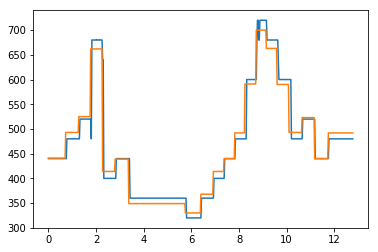

In [18]:
#plt.plot(k[:(len(k)-1)],Y1[:(len(k)-1)])
plt.plot(k_1,Y1)
plt.plot(k_1,Notes_précises)
score=sklearn.metrics.r2_score(Y1,Notes_précises) 
print(score)
len(Y1),len(Notes_précises)

On observe plusieurs choses. La FFT semble parvenir à restituer le reste des notes avec seulement une petite erreur de fréquence. Le problème principal de cette méthode est que nous ne pouvons détecter les faibles variations de fréquence avec cette méthode.


### 2.1 Périodogramme

Nous allons refaire la méthode précédente avec cette fois un périodogramme de Bartlett au lieu de calculs de transformées de Fourier. Puisque densité spectrale et transformées de Fourier sont intimement liées, nous nous attendons à obtenir un résultat à peu près similaire au précédent.

on peut facilement récupérer le pic d'amplitude maximale pour déterminer la note jouée sur la fenêtre de temps. On refait donc le processus sur toutes les fenêtres et on trace les fréquences détectées en fonction du temps.

In [19]:
Ts = []
eps_2 = 10
to_2 = to
k_2 = np.arange(0,dur,to_2)
ymax = 0
n = 0
t = float(1/fs)
Y2 = []
for i in k_2:
    f, Pxx_spec = scs.periodogram(wave[int(i*N1/dur):int((i+to_2)*N1/dur)], fs, 'flattop', scaling='spectrum')
    y2 = abs(f[np.argmax(Pxx_spec)])
    Y2.append(y2)
    if (abs(y2-ymax)>eps_2):
        Ts.append(i)
    ymax = y2



Ts.append(dur)

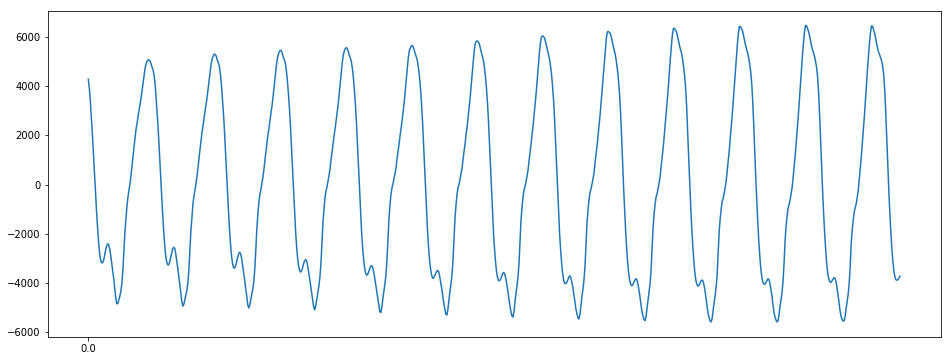

480.0


(0, 5000)

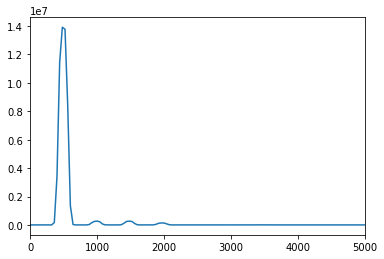

In [20]:
plotwave(fs, wave1)
fu, Pxx_specu = scs.periodogram(wave1, fs, 'flattop', scaling='spectrum')
plt.plot(fu,Pxx_specu)
print(abs(fu[np.argmax(Pxx_specu)]))
plt.xlim(0,5000)

In [21]:
notes1=collections.OrderedDict()
for t in range(len(Ts)-1):
    lo = len(wave[int(Ts[t]*N1/dur):int(Ts[t+1]*N1/dur)])
    f, Pxx_spec = scs.periodogram(wave[int(Ts[t]*N1/dur):int(Ts[t+1]*N1/dur)], fs, 'flattop', scaling='spectrum')
    note1=abs(f[np.argmax(Pxx_spec)])
    notes1[str(round(Ts[t],3))+' to '+str(round(Ts[t+1],3))]=[note1]
    notes1[str(round(Ts[t],3))+' to '+str(round(Ts[t+1],3))].append(pitch(note1))

for t in range(len(Ts)-1):
    sine(frequency=notes1[str(round(Ts[t],3))+' to '+str(round(Ts[t+1],3))][0], duration=Ts[t+1]-Ts[t])
notes1

OrderedDict([('0.0 to 0.025', [480.0, 'B4.0']),
             ('0.025 to 0.775', [437.3333333333333, 'A4.0']),
             ('0.775 to 1.325', [492.7272727272727, 'B4.0']),
             ('1.325 to 1.8', [526.3157894736842, 'C5.0']),
             ('1.8 to 1.825', [440.0, 'A4.0']),
             ('1.825 to 2.275', [662.2222222222223, 'E5.0']),
             ('2.275 to 2.3', [640.0, 'D#5.0']),
             ('2.3 to 2.325', [680.0, 'F5.0']),
             ('2.325 to 2.875', [414.5454545454545, 'G#4.0']),
             ('2.875 to 3.425', [436.3636363636364, 'A4.0']),
             ('3.425 to 3.45', [360.0, 'F#4.0']),
             ('3.45 to 3.475', [320.0, 'D#4.0']),
             ('3.475 to 5.8', [347.9569892473118, 'F4.0']),
             ('5.8 to 6.425', [328.0, 'E4.0']),
             ('6.425 to 6.45', [360.0, 'F#4.0']),
             ('6.45 to 6.475', [400.0, 'G4.0']),
             ('6.475 to 6.95', [368.4210526315789, 'F#4.0']),
             ('6.95 to 6.975', [440.0, 'A4.0']),
             ('6.9

In [52]:

for t in range(len(Ts)-1):
    sine(frequency=notes1[str(round(Ts[t],3))+' to '+str(round(Ts[t+1],3))][0], duration=Ts[t+1]-Ts[t])
notes1

OrderedDict([('0.0 to 0.025', [480.0, 'B4.0']),
             ('0.025 to 0.775', [437.3333333333333, 'A4.0']),
             ('0.775 to 1.325', [492.7272727272727, 'B4.0']),
             ('1.325 to 1.8', [526.3157894736842, 'C5.0']),
             ('1.8 to 1.825', [440.0, 'A4.0']),
             ('1.825 to 2.275', [662.2222222222223, 'E5.0']),
             ('2.275 to 2.3', [640.0, 'D#5.0']),
             ('2.3 to 2.325', [680.0, 'F5.0']),
             ('2.325 to 2.875', [414.5454545454545, 'G#4.0']),
             ('2.875 to 3.425', [436.3636363636364, 'A4.0']),
             ('3.425 to 3.45', [360.0, 'F#4.0']),
             ('3.45 to 3.475', [320.0, 'D#4.0']),
             ('3.475 to 5.8', [347.9569892473118, 'F4.0']),
             ('5.8 to 6.425', [328.0, 'E4.0']),
             ('6.425 to 6.45', [360.0, 'F#4.0']),
             ('6.45 to 6.475', [400.0, 'G4.0']),
             ('6.475 to 6.95', [368.4210526315789, 'F#4.0']),
             ('6.95 to 6.975', [440.0, 'A4.0']),
             ('6.9

0.9262956740699333


(512, 512)

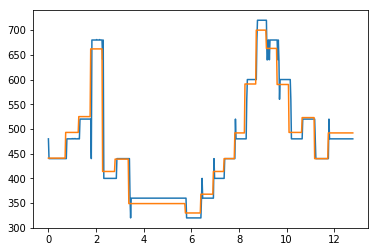

In [22]:
plt.plot(k_2,Y2)
plt.plot(k_2,Notes_précises)

score1=sklearn.metrics.r2_score(Y2,Notes_précises) 
print(score1)

len(Y2),len(Notes_précises)

Comme prévu, on récupère les mêmes avantages et inconvénients qu’avec la FFT : plutôt bonne détection des notes en dehors des périodes de transition mais incapacité à trouver les faibles variations de fréquence. Nous sommes donc passés à des méthodes  parametriques pour tenter de détecter ceux-ci.

## 3 Algorithmes paramétriques

### 3.1 Algorithme de Burg

In [23]:
#burg 
#Algorithme a exécuté sur chaque période => très couteux en temps de calcul
#a expliqué
#pics : selectionné lors du dépassement d'une valeur max (-40) 

Tb = []
eps_3 = 20
to_3 = to
lu = np.arange(0,dur,to_3)
ymax = 0
Y3 = []

for i in lu:
    AR, P, k = arburg(wave[int(i*N1/dur):int((i+to_3)*N1/dur)], 100)
    PSD = arma2psd(AR, sides='centerdc')
    f = linspace(-0.5, 0.5, len(PSD))*fs
    peaks, _ = scs.find_peaks(10*log10(PSD),height=-38)
    peaks = peaks[np.where(abs(f[peaks])>250)]
    y3 = min(abs(f[peaks]))
    Y3.append(y3)
    if (abs(y3-ymax)>eps_3):
        Tb.append(i)
    ymax=y3



Tb.append(dur)

In [24]:
F0 = [441]*2
F1 = [441]*len(np.arange(int((0.38/to_3)),int((1.06/to_3))))
F2 = [493]*len(np.arange(int((1.06/to_3)),int((1.6/to_3))))
F3 = [525]*len(np.arange(int((1.6/to_3)),int((2.1/to_3))))
F4 = [662]*len(np.arange(int((2.1/to_3)),int((2.6/to_3))))
F5 = [414]*len(np.arange(int((2.6/to_3)),int((3.15/to_3))))
F6 = [439]*len(np.arange(int((3.15/to_3)),int((3.7/to_3))))
F7 = [349]*len(np.arange(int((3.7/to_3)),int((6.1/to_3))))
F8 = [330]*len(np.arange(int((6.1/to_3)),int((6.735/to_3))))
F9 = [368]*len(np.arange(int((6.735/to_3)),int((7.25/to_3))))
F10 = [414]*len(np.arange(int((7.25/to_3)),int((7.7/to_3))))
F11 = [440]*len(np.arange(int((7.7/to_3)),int((8.15/to_3))))
F12 = [492]*len(np.arange(int((8.15/to_3)),int((8.6/to_3))))
F13 = [591]*len(np.arange(int((8.6/to_3)),int((9.05/to_3))))
F14 = [700]*len(np.arange(int((9.05/to_3)),int((9.48/to_3))))
F15 = [663]*len(np.arange(int((9.48/to_3)),int((9.95/to_3))))
F16 = [590]*len(np.arange(int((9.95/to_3)),int((10.45/to_3))))
F17 = [493]*len(np.arange(int((10.45/to_3)),int((10.98/to_3))))
F18 = [523]*len(np.arange(int((10.98/to_3)),int((11.5/to_3))))
F19 = [440]*len(np.arange(int((11.5/to_3)),int((12.08/to_3))))
F20 = [492]*len(np.arange(int((12.08/to_3)),int((13.10/to_3))))
F21 = [492]
Notes_précises1 = F0+F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21

0.833933207246286


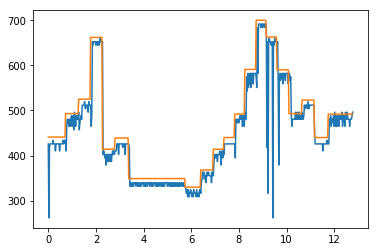

In [25]:
plt.plot(lu,Y3)
plt.plot(np.arange(0,dur,to_3),Notes_précises1)
score3 = sklearn.metrics.r2_score(Y3,Notes_précises1) 
print(score3)

In [26]:
notes3=  collections.OrderedDict()

for t in range(len(Tb)-1):
    AR, P, k = arburg(wave[int(Tb[t]*N1/dur):int(Tb[t+1]*N1/dur)], 100)
    PSD = arma2psd(AR, sides='centerdc')
    f = linspace(-0.5, 0.5, len(PSD))*fs
    peaks, _ = scs.find_peaks(10*log10(PSD/max(PSD)),height=-45)
    peaks = peaks[np.where(abs(f[peaks])>250)]
    note3 = min(abs(f[peaks]))
    notes3[str(round(Tb[t],3))+' to '+str(round(Tb[t+1],3))]=[note3]
    notes3[str(round(Tb[t],3))+' to '+str(round(Tb[t+1],3))].append(pitch(note3))

notes3

OrderedDict([('0.0 to 0.025', [425.88522588522613, 'G#4.0']),
             ('0.025 to 0.05', [261.7826617826626, 'C4.0']),
             ('0.05 to 0.75', [425.88522588522613, 'G#4.0']),
             ('0.75 to 0.775', [410.25641025641056, 'G#4.0']),
             ('0.775 to 1.0', [480.58608058608064, 'B4.0']),
             ('1.0 to 1.075', [480.58608058608064, 'B4.0']),
             ('1.075 to 1.1', [457.1428571428573, 'A#4.0']),
             ('1.1 to 1.175', [480.58608058608064, 'B4.0']),
             ('1.175 to 1.3', [480.58608058608064, 'B4.0']),
             ('1.3 to 1.425', [480.58608058608064, 'B4.0']),
             ('1.425 to 1.7', [511.8437118437118, 'C5.0']),
             ('1.7 to 1.8', [511.8437118437118, 'C5.0']),
             ('1.8 to 1.825', [464.95726495726507, 'A#4.0']),
             ('1.825 to 1.85', [488.4004884004884, 'B4.0']),
             ('1.85 to 2.3', [652.503052503052, 'E5.0']),
             ('2.3 to 2.425', [402.4420024420028, 'G4.0']),
             ('2.425 to 2.4

In [53]:
for t in range(len(Tb)-1):
    sine(frequency=notes3[str(round(Tb[t],3))+' to '+str(round(Tb[t+1],3))][0], duration=Tb[t+1]-Tb[t])

574.3589743589741

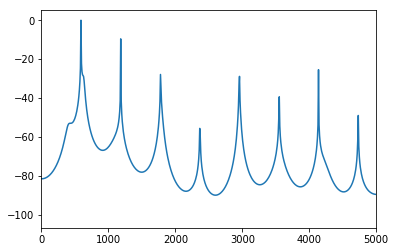

In [28]:
AR, P, k = arburg(wave[int(9.7*N1/dur):int(9.73*N1/dur)], 100)
PSD = arma2psd(AR, sides='centerdc')
f = linspace(-0.5, 0.5, len(PSD))*fs

plt.plot(f, 10*log10(PSD/max(PSD)))
plt.xlim(0,5000)
#f=f[int(len(PSD)/2-len(PSD)/50):int(len(PSD)/2+len(PSD)/50)]
#PSD=PSD[int(len(PSD)/2-len(PSD)/50):int(len(PSD)/2+len(PSD)/50)]
peaks, _ = scs.find_peaks(10*log10(PSD/max(PSD)), height=-45)
peaks = peaks[np.where(abs(f[peaks])>100)]
min(abs(f[peaks]))


### 3.2 Algorithme MUSIC 

In [29]:
#Music

Tm = []
eps_4 = 20
to_4 = to
lm = np.arange(0,dur,to_4)
ymax = 0
Y4 = []

for i in lm:
    p = pmusic(wave[int(i*N1/dur):int((i+to_4)*N1/dur)], 320,NFFT=4096,sampling=fs)
    Fr = p.frequencies()
    peaks, _ = scs.find_peaks(mag2db(p.psd),height=6)
    peaks.tolist()
    F = []
    for k in range(len(peaks)):
        F.append(Fr[peaks[k]])
    F = [f for f in F if f>325]
    y4 = min(F)
    Y4.append(y4)
    if (abs(y4-ymax)>eps_4):
        Tm.append(i)
    ymax = y4

Tm.append(dur)

In [30]:
F0 = [441]*2
F1 = [441]*len(np.arange(int((0.38/to_4)),int((1.06/to_4))))
F2 = [493]*len(np.arange(int((1.06/to_4)),int((1.6/to_4))))
F3 = [525]*len(np.arange(int((1.6/to_4)),int((2.1/to_4))))
F4 = [662]*len(np.arange(int((2.1/to_4)),int((2.6/to_4))))
F5 = [414]*len(np.arange(int((2.6/to_4)),int((3.15/to_4))))
F6 = [439]*len(np.arange(int((3.15/to_4)),int((3.7/to_4))))
F7 = [349]*len(np.arange(int((3.7/to_4)),int((6.1/to_4))))
F8 = [330]*len(np.arange(int((6.1/to_4)),int((6.735/to_4))))
F9 = [368]*len(np.arange(int((6.735/to_4)),int((7.25/to_4))))
F10 = [414]*len(np.arange(int((7.25/to_4)),int((7.7/to_4))))
F11 = [440]*len(np.arange(int((7.7/to_4)),int((8.15/to_4))))
F12 = [492]*len(np.arange(int((8.15/to_4)),int((8.6/to_4))))
F13 = [591]*len(np.arange(int((8.6/to_4)),int((9.05/to_4))))
F14 = [700]*len(np.arange(int((9.05/to_4)),int((9.48/to_4))))
F15 = [663]*len(np.arange(int((9.48/to_4)),int((9.95/to_4))))
F16 = [590]*len(np.arange(int((9.95/to_4)),int((10.45/to_4))))
F17 = [493]*len(np.arange(int((10.45/to_4)),int((10.98/to_4))))
F18 = [523]*len(np.arange(int((10.98/to_4)),int((11.5/to_4))))
F19 = [440]*len(np.arange(int((11.5/to_4)),int((12.08/to_4))))
F20 = [492]*len(np.arange(int((12.08/to_4)),int((13.10/to_4))))
F21 = [492]
Notes_précises3 = F0+F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21

0.2131550809029753


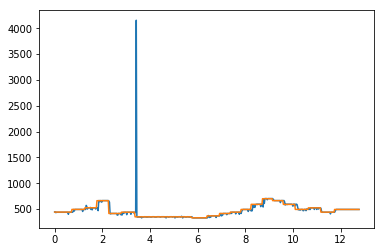

In [31]:
plt.plot(lm,Y4)

plt.plot(np.arange(0,dur,to_4),Notes_précises3)
score4=sklearn.metrics.r2_score(Y4,Notes_précises3) 
print(score4)

(250, 750)

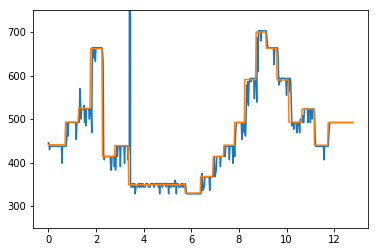

In [32]:
plt.plot(lm,Y4)

plt.plot(np.arange(0,dur,to_4),Notes_précises3)

plt.ylim(250,750)

In [33]:
notes4 = collections.OrderedDict()
for t in range(len(Tm)-1):
    p = pmusic(wave[int(Tm[t]*N1/dur):int(Tm[t+1]*N1/dur)], 300,NFFT=4096,sampling=fs)
    Fr = p.frequencies()
    peaks, _ = scs.find_peaks(mag2db(p.psd),height=7)
    peaks.tolist()
    F=  []
    for k in range(len(peaks)):
        F.append(Fr[peaks[k]])
    F = [f for f in F if f>325]
    note4 = min(F)
    notes4[str(round(Tm[t],3))+' to '+str(round(Tm[t+1],3))]=[note4]
    notes4[str(round(Tm[t],3))+' to '+str(round(Tm[t+1],3))].append(pitch(note4))

notes4

OrderedDict([('0.0 to 0.575', [445.3125, 'A4.0']),
             ('0.575 to 0.6', [398.4375, 'G4.0']),
             ('0.6 to 0.8', [437.5, 'A4.0']),
             ('0.8 to 0.825', [492.1875, 'B4.0']),
             ('0.825 to 0.85', [460.9375, 'A#4.0']),
             ('0.85 to 1.175', [492.1875, 'B4.0']),
             ('1.175 to 1.2', [453.125, 'A#4.0']),
             ('1.2 to 1.325', [492.1875, 'B4.0']),
             ('1.325 to 1.35', [570.3125, 'C#5.0']),
             ('1.35 to 1.375', [539.0625, 'C#5.0']),
             ('1.375 to 1.4', [500.0, 'B4.0']),
             ('1.4 to 1.525', [523.4375, 'C5.0']),
             ('1.525 to 1.55', [492.1875, 'B4.0']),
             ('1.55 to 1.575', [523.4375, 'C5.0']),
             ('1.575 to 1.6', [492.1875, 'B4.0']),
             ('1.6 to 1.725', [523.4375, 'C5.0']),
             ('1.725 to 1.75', [523.4375, 'C5.0']),
             ('1.75 to 1.825', [523.4375, 'C5.0']),
             ('1.825 to 1.85', [468.75, 'A#4.0']),
             ('1.85 to 1.9',

In [34]:
for t in range(len(Tm)-1):
    sine(frequency=notes4[str(round(Tm[t],3))+' to '+str(round(Tm[t+1],3))][0], duration=Tm[t+1]-Tm[t])

578.125

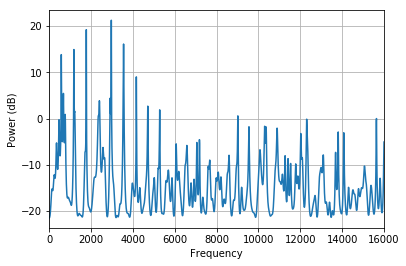

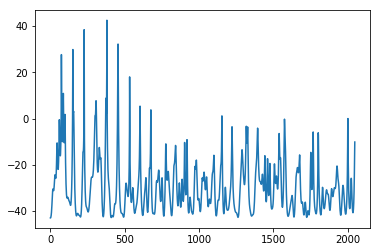

In [35]:
#music

p = pmusic(wave[int(9.675*N1/dur):int(9.7*N1/dur)], 300,NFFT=4096,sampling=fs)
p()
p.plot()
Fr=p.frequencies()
plt.figure()
plt.plot(mag2db(p.psd))
peaks, _ = scs.find_peaks(mag2db(p.psd),height=0)
#Fr[peaks]
peaks.tolist()
F = []
for k in range(len(peaks)):
    F.append(Fr[peaks[k]])
F = [f for f in F if f>250]
F
min(F)

## Algorithme de Yule-Walker

In [36]:
#Yule Walker
to_5=to
from spectrum import *
Ty=[]
eps_5=20
ly=np.arange(0,dur,to_5)
ymax=0

Y5=[]
for i in ly:
    AR, P, k = aryule(wave[int(i*N1/dur):int((i+to_5)*N1/dur)], 200)
    PSD = arma2psd(AR, sides='centerdc')
    f=linspace(-0.5, 0.5, len(PSD))*fs
    #peaks, _ = scs.find_peaks(10*log10(PSD))
    peaks, _ = scs.find_peaks(PSD/max(PSD))
    peaks = peaks[np.where(abs(f[peaks])>300)]
    y5=min(abs(f[peaks]))
    Y5.append(y5)
    if (abs(y5-ymax)>eps_5):
        Ty.append(i)
    ymax=y5



Ty.append(dur)

C:\Users\Omar\AppData\Local\Continuum\anaconda3\lib\site-packages\spectrum\correlation.py:125: RuntimeWarning: overflow encountered in short_scalars
  sum = sum + x[j+k] * y[j]


-1.8454349764414633


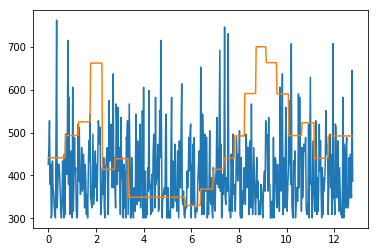

In [37]:
plot(ly,Y5)

plot(np.arange(0,dur,to_5),Notes_précises3)
score5=sklearn.metrics.r2_score(Y5,Notes_précises3) 
print(score5)


C:\Users\Omar\AppData\Local\Continuum\anaconda3\lib\site-packages\spectrum\correlation.py:125: RuntimeWarning: overflow encountered in short_scalars
  sum = sum + x[j+k] * y[j]


378.9987789987794

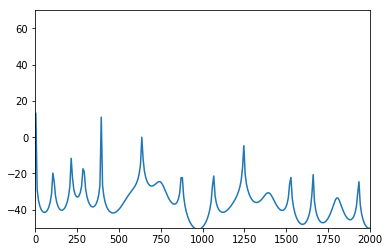

In [38]:
#yule walker
from spectrum import pmusic
AR, P, k = aryule(wave[int(1.0*N1/dur):int(1.025*N1/dur)],350)
PSD = arma2psd(AR, sides='centerdc')
f=linspace(-0.5, 0.5, len(PSD))*fs
plt.plot(f, 10*log10(PSD))
#plt.plot(f, abs(PSD))
plt.xlim(0,2000)
plt.ylim(-50,70)
peaks, _ = scs.find_peaks(10*log10(PSD))
#peaks, _ = scs.find_peaks(PSD/max(PSD))
peaks = peaks[np.where(abs(f[peaks])>300)]
fmin=min(abs(f[peaks]))

fmin

In [39]:
score_2_1 = 0
score_2_2 = 0
score_2_3 = 0 
score_2_4 = 0
score_2_5 = 0

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=['Algorithmes','Fenêtrage Rect', 'Fenêtrage Hamming'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[['FFT','Périodogramme','Burg','MUSIC', 'Yule Walker'],
                       [score_1_1, score_1_2, score_1_3, score_1_4, score_1_5], # 1st column
                       [score_2_1, score_2_2, score_2_3, score_2_4, score_2_5]], # 2nd column
               line_color='darkslategray',
               fill_color=dict(color=['lightskyblue', 'lightcyan', 'lightcyan']),
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()

NameError: name 'score_1_1' is not defined

C:\Users\Omar\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\spectral.py:1970: UserWarning:

nperseg = 855 is greater than input length  = 799, using nperseg = 799



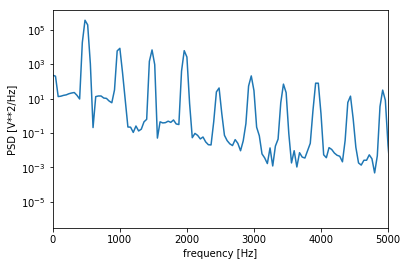

480.60075093867334


In [40]:
n1=to*N/12.8
f, Pxx_den=scipy.signal.welch(wave[int(1.0*N1/dur):int(1.025*N1/dur)], fs=fs, window='hamming', nperseg=n1)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0,5000)
plt.show()
print(abs(f[np.argmax(Pxx_specu)]))


In [41]:
#burg avec fenetre de Hamming
Tbw = []
eps_6 = 20
to_6 = to
lbw = np.arange(0,dur,to_6)
ymax = 0
Y6 = []

for i in lbw:
    window=scipy.signal.windows.hamming(len(wave[int(i*N1/dur):int((i+to_6)*N1/dur)]),sym=False)
    sig=wave[int(i*N1/dur):int((i+to_6)*N1/dur)]*window
    AR, P, k = arburg(sig, 100)
    PSD = arma2psd(AR, sides='centerdc')
    f = linspace(-0.5, 0.5, len(PSD))*fs
    peaks, _ = scs.find_peaks(10*log10(PSD),height=-38)
    peaks = peaks[np.where(abs(f[peaks])>250)]
    y6 = min(abs(f[peaks]))
    Y6.append(y6)
    if (abs(y6-ymax)>eps_6):
        Tbw.append(i)
    ymax=y6



Tbw.append(dur)

0.8306416013459764


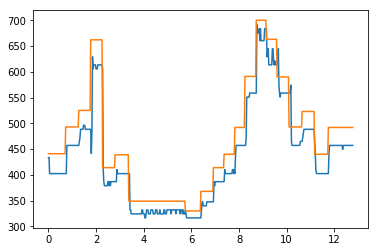

In [42]:
plt.plot(lbw,Y6)
plt.plot(np.arange(0,dur,to_6),Notes_précises1)
score6 = sklearn.metrics.r2_score(Y6,Notes_précises1) 
print(score6)

In [43]:
notes6=  collections.OrderedDict()

for t in range(len(Tbw)-1):
    window=scipy.signal.windows.hamming(len(wave[int(Tbw[t]*N1/dur):int(Tbw[t+1]*N1/dur)]),sym=False)
    sig=wave[int(Tbw[t]*N1/dur):int(Tbw[t+1]*N1/dur)]*window
    AR, P, k = arburg(sig, 100)
    PSD = arma2psd(AR, sides='centerdc')
    f = linspace(-0.5, 0.5, len(PSD))*fs
    peaks, _ = scs.find_peaks(10*log10(PSD/max(PSD)),height=-45)
    peaks = peaks[np.where(abs(f[peaks])>250)]
    note6 = min(abs(f[peaks]))
    notes6[str(round(Tbw[t],3))+' to '+str(round(Tbw[t+1],3))]=[note6]
    notes6[str(round(Tbw[t],3))+' to '+str(round(Tbw[t+1],3))].append(pitch(note6))

notes6

OrderedDict([('0.0 to 0.05', [433.6996336996339, 'A4.0']),
             ('0.05 to 0.775', [425.88522588522613, 'G#4.0']),
             ('0.775 to 1.8', [480.58608058608064, 'B4.0']),
             ('1.8 to 1.825', [441.5140415140417, 'A4.0']),
             ('1.825 to 1.85', [480.58608058608064, 'B4.0']),
             ('1.85 to 1.875', [629.0598290598286, 'D#5.0']),
             ('1.875 to 2.3', [652.503052503052, 'E5.0']),
             ('2.3 to 2.325', [410.25641025641056, 'G#4.0']),
             ('2.325 to 2.875', [402.4420024420028, 'G4.0']),
             ('2.875 to 3.425', [425.88522588522613, 'G#4.0']),
             ('3.425 to 6.95', [332.1123321123327, 'E4.0']),
             ('6.95 to 7.4', [402.4420024420028, 'G4.0']),
             ('7.4 to 7.85', [425.88522588522613, 'G#4.0']),
             ('7.85 to 7.875', [433.6996336996339, 'A4.0']),
             ('7.875 to 8.325', [480.58608058608064, 'B4.0']),
             ('8.325 to 8.75', [582.1733821733819, 'D5.0']),
             ('8.75 

In [44]:
for t in range(len(Tbw)-1):
    sine(frequency=notes6[str(round(Tbw[t],3))+' to '+str(round(Tbw[t+1],3))][0], duration=Tbw[t+1]-Tbw[t])

In [45]:
#Music with windowing 
Tmw = []
eps_7 = 20
to_7 = to
lmw = np.arange(0,dur,to_7)
ymax = 0
Y7 = []

for i in lmw:
    window=scipy.signal.windows.hamming(len(wave[int(i*N1/dur):int((i+to_7)*N1/dur)]),sym=False)
    sig=wave[int(i*N1/dur):int((i+to_7)*N1/dur)]*window
    p = pmusic(sig, 320,NFFT=4096,sampling=fs)
    Fr = p.frequencies()
    peaks, _ = scs.find_peaks(mag2db(p.psd),height=0)
    peaks.tolist()
    F = []
    for k in range(len(peaks)):
        F.append(Fr[peaks[k]])
    F = [f for f in F if f>325]
    y7 = min(F)
    Y7.append(y7)
    if (abs(y7-ymax)>eps_4):
        Tmw.append(i)
    ymax = y7

Tmw.append(dur)

0.7894916162910042


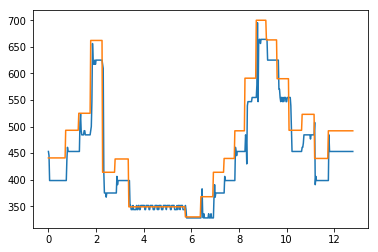

In [46]:
plt.plot(lmw,Y7)

plt.plot(np.arange(0,dur,to_7),Notes_précises3)
score7=sklearn.metrics.r2_score(Y7,Notes_précises3) 
print(score7)

In [47]:
#Retire les fréquences fondamentales à chaque intervalle to_1
Tnw = []
eps_8 = 5
to_8 = to
k_8 = np.arange(0,dur,to_8)
ymax = 0
n = 0
t = float(1/fs)
Y8 = []
for i in k_8:
    window=scipy.signal.windows.hamming(len(wave[int(i*N1/dur):int((i+to_7)*N1/dur)]),sym=False)
    sig=wave[int(i*N1/dur):int((i+to_7)*N1/dur)]*window
    n = len(sig)
    Y = scipy.fftpack.fft(sig)
    freq = scipy.fftpack.fftfreq(n) * fs
    y8 = abs(freq[np.argmax(abs(Y))])
    Y8.append(y8)
#    plt.plot(freq,abs(Y))
#    plt.xlim(0,4500)
#    plt.figure()
    if (abs(y8-ymax)>eps_8):
        Tnw.append(i)
    ymax = y8

0.9335412771158579


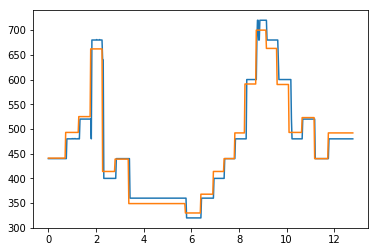

In [48]:
plt.plot(k_8,Y8)
plt.plot(k_8,Notes_précises)
score8=sklearn.metrics.r2_score(Y8,Notes_précises) 
print(score8)

In [49]:
Tsw = []
eps_9 = 10
to_9 = to
k_9 = np.arange(0,dur,to_9)
ymax = 0
n = 0
t = float(1/fs)
Y9 = []
for i in k_9:
    window=scipy.signal.windows.hamming(len(wave[int(i*N1/dur):int((i+to_9)*N1/dur)]),sym=False)
    sig=wave[int(i*N1/dur):int((i+to_9)*N1/dur)]*window
    f, Pxx_spec = scs.periodogram(sig, fs, 'flattop', scaling='spectrum')
    y9 = abs(f[np.argmax(Pxx_spec)])
    Y9.append(y9)
    if (abs(y9-ymax)>eps_9):
        Tsw.append(i)
    ymax = y9



Tsw.append(dur)

0.9272479808233407


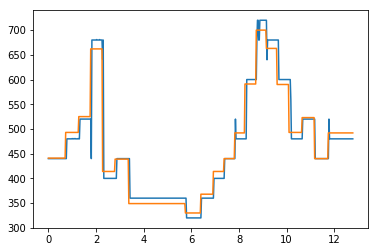

In [50]:
plt.plot(k_9,Y9)
plt.plot(k_9,Notes_précises)
score9=sklearn.metrics.r2_score(Y9,Notes_précises) 
print(score9)

In [ ]:
''